###  BGL Dataset - Exploratory Data Analysis

**Dataset Source:**  BlueGene/L Supercomputer (LLNL) - LogHub BGL \
**Citation:**: Oliner et al. (DSN 2007), He et al. (ICWS 2017)

#### Overview
This notebook explores the pre-processed BGL dataset which includes:

- 949,589 log sequences (generated via Sliding Window, size=20)
- 369 unique log templates (extracted via Drain3)
- Binary labels (Normal/Anomaly) derived from alert categories
- ~4.7M raw log entries processed

#### Objectives
1. Understand data structure and format
2. Analyze sequence characteristics
3. Compare normal vs anomaly patterns
4. Generate statistics for thesis Chapter 5.1

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Create figures directory
import os
os.makedirs('../figures', exist_ok=True)

print("✓ Libraries loaded successfully")

✓ Libraries loaded successfully


---
## 1. Data Loading
Load all preprocessed files and understand their structure.

In [2]:
# Define paths
DATA_DIR = '../data/bgl/preprocessed'

In [3]:
# 1.1 Load Templates
templates_df = pd.read_csv(f'{DATA_DIR}/BGL.log_templates.csv')
print(f"\n Templates (Total: {len(templates_df)})")
print("-" * 60)
print(templates_df.head())
print("\nTemplates loaded")


 Templates (Total: 369)
------------------------------------------------------------
  EventId                              EventTemplate  OccurrenceCount
0      E3                      generating core.<NUM>          1706751
1    E417                           iar <*> dear <*>           442966
2     E11   <NUM> double-hummer alignment exceptions           295764
3    E227  <NUM> floating point alignment exceptions           267725
4      E6              CE sym <NUM>, at <*> mask <*>           201206

Templates loaded


In [5]:
# 1.2 Load Sequences
sequences_data = np.load(f'{DATA_DIR}/sequences.npz', allow_pickle=True)
print("\n=== Sequences NPZ Contents ===")
for key in sequences_data.files:
    arr = sequences_data[key]
    if hasattr(arr, 'shape'):
        print(f"{key}: shape={arr.shape}, dtype={arr.dtype}")
    else:
        print(f"{key}: {type(arr)}")

# Extract sequences and labels
sequences = sequences_data['x_data'] 
labels = sequences_data['y_data'] 

print(f"\n✓ Sequences shape: {sequences.shape}")
print(f"✓ Labels shape: {labels.shape}")
print(f"\nFirst sequence (all 20 events): {sequences[0]}")
print(f"First label: {labels[0]} ({'Normal' if labels[0] == 0 else 'Anomaly'})")

# Check class distribution
n_normal = np.sum(labels == 0)
n_anomaly = np.sum(labels == 1)
print(f"\nClass distribution:")
print(f"  Normal: {n_normal:,} ({n_normal/len(labels)*100:.2f}%)")
print(f"  Anomaly: {n_anomaly:,} ({n_anomaly/len(labels)*100:.2f}%)")


=== Sequences NPZ Contents ===
x_data: shape=(949589, 20), dtype=int32
y_data: shape=(949589,), dtype=int32

✓ Sequences shape: (949589, 20)
✓ Labels shape: (949589,)

First sequence (all 20 events): [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
First label: 0 (Normal)

Class distribution:
  Normal: 868,556 (91.47%)
  Anomaly: 81,033 (8.53%)


---
## 2. Basic Statistics
Compute fundamental dataset statistics.

In [7]:
# 2.1 Overall Dataset Statistics
print("\n" + "=" * 60)
print("BGL DATASET STATISTICS")
print("=" * 60)

# Load vocabulary
import pickle
with open(f"{DATA_DIR}/vocabulary.pkl", "rb") as f:
    vocabulary = pickle.load(f)

n_sequences = len(sequences)
n_normal = np.sum(labels == 0)
n_anomaly = np.sum(labels == 1)
anomaly_rate = n_anomaly / n_sequences * 100

# Sequence lengths
seq_lengths = []
for seq in sequences:
    non_padding = seq[seq > 0]  
    seq_lengths.append(len(non_padding) if len(non_padding) > 0 else len(seq))

stats = {
    "Total Sequences": f"{n_sequences:,}",
    "Normal Sequences": f"{n_normal:,} ({n_normal/n_sequences*100:.2f}%)",
    "Anomaly Sequences": f"{n_anomaly:,} ({n_anomaly/n_sequences*100:.2f}%)",
    "Anomaly Rate (%)": f"{anomaly_rate:.2f}%",
    "Unique Templates": len(templates_df),
    "Vocabulary Size": len(vocabulary),
}

print("\n" + "DATASET SIZE".ljust(60, "."))
for key, value in stats.items():
    print(f"{key:.<40} {str(value):>15}")

print(f"\n{'SEQUENCE LENGTH STATS':.<40}")
print(f"  Fixed Window Size:......................... {sequences.shape[1]}")
print(f"  Mean Effective Length:..................... {np.mean(seq_lengths):.2f}")
print(f"  Median Effective Length:................... {np.median(seq_lengths):.0f}")
print(f"  Min Length:................................ {np.min(seq_lengths)}")
print(f"  Max Length:................................ {np.max(seq_lengths)}")



BGL DATASET STATISTICS

DATASET SIZE................................................
Total Sequences.........................         949,589
Normal Sequences........................ 868,556 (91.47%)
Anomaly Sequences.......................  81,033 (8.53%)
Anomaly Rate (%)........................           8.53%
Unique Templates........................             369
Vocabulary Size.........................             371

SEQUENCE LENGTH STATS...................
  Fixed Window Size:......................... 20
  Mean Effective Length:..................... 20.00
  Median Effective Length:................... 20
  Min Length:................................ 20
  Max Length:................................ 20


---
## 3. Template Analysis

In [8]:
print("\n" + "="*70)
print("TEMPLATE ANALYSIS")
print("="*70)

# Sort by occurrences
templates_sorted = templates_df.sort_values('OccurrenceCount', ascending=False)

print("\nTop 20 Most Frequent Templates:")
print("-" * 100)
for idx, row in templates_sorted.head(20).iterrows():
    event_id = row['EventId']
    template = row['EventTemplate']
    count = row['OccurrenceCount']
    pct = count / templates_sorted['OccurrenceCount'].sum() * 100
    # Truncate long templates
    template_short = template[:60] + '...' if len(template) > 60 else template
    print(f"{event_id:6s} | {count:>10,} ({pct:>5.2f}%) | {template_short}")

print("\n\nBottom 20 Least Frequent Templates:")
print("-" * 100)
for idx, row in templates_sorted.tail(20).iterrows():
    event_id = row['EventId']
    template = row['EventTemplate']
    count = row['OccurrenceCount']
    pct = count / templates_sorted['OccurrenceCount'].sum() * 100
    template_short = template[:60] + '...' if len(template) > 60 else template
    print(f"{event_id:6s} | {count:>10,} ({pct:>5.2f}%) | {template_short}")


TEMPLATE ANALYSIS

Top 20 Most Frequent Templates:
----------------------------------------------------------------------------------------------------
E3     |  1,706,751 (35.96%) | generating core.<NUM>
E417   |    442,966 ( 9.33%) | iar <*> dear <*>
E11    |    295,764 ( 6.23%) | <NUM> double-hummer alignment exceptions
E227   |    267,725 ( 5.64%) | <NUM> floating point alignment exceptions
E6     |    201,206 ( 4.24%) | CE sym <NUM>, at <*> mask <*>
E18    |    152,734 ( 3.22%) | data TLB error interrupt
E1036  |    135,092 ( 2.85%) | <NUM> total interrupts. <NUM> critical input interrupts. <NU...
E1035  |    135,092 ( 2.85%) | <NUM> microseconds spent in the rbs signal handler during <N...
E1     |    105,924 ( 2.23%) | instruction cache parity error corrected
E382   |     84,250 ( 1.78%) | idoproxydb hit ASSERT condition: ASSERT <*> Source <*> Sourc...
E158   |     63,493 ( 1.34%) | data storage interrupt
E407   |     62,484 ( 1.32%) | ciod: generated <NUM> core files for progr

## 4. TEMPLATE FREQUENCY VISUALIZATION 

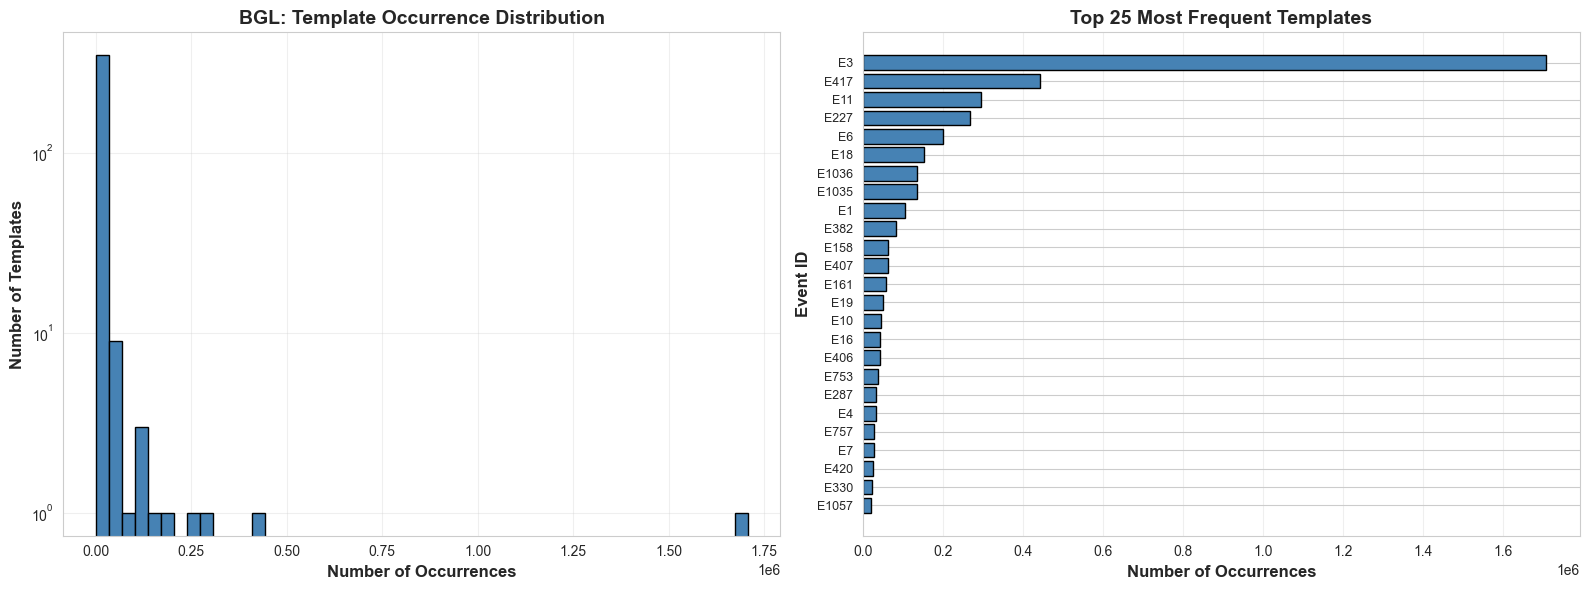

✓ Saved: ../figures/bgl_template_distribution.png


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

  # Plot 1: Template occurrence distribution
axes[0].hist(templates_sorted['OccurrenceCount'], bins=50, edgecolor='black', color='steelblue')
axes[0].set_xlabel('Number of Occurrences', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Templates', fontsize=12, fontweight='bold')
axes[0].set_title('BGL: Template Occurrence Distribution', fontsize=14, fontweight='bold')
axes[0].set_yscale('log')
axes[0].grid(True, alpha=0.3)

# Plot 2: Top 25 templates
top_n = 25
top_templates = templates_sorted.head(top_n)
y_pos = np.arange(len(top_templates))
axes[1].barh(y_pos, top_templates['OccurrenceCount'].values, color='steelblue', edgecolor='black')
axes[1].set_yticks(y_pos)
axes[1].set_yticklabels(top_templates['EventId'].values, fontsize=9)
axes[1].set_xlabel('Number of Occurrences', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Event ID', fontsize=12, fontweight='bold')
axes[1].set_title(f'Top {top_n} Most Frequent Templates', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../figures/bgl_template_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: ../figures/bgl_template_distribution.png")

 ## SECTION 5. EVENT FREQUENCY ANALYSIS

In [11]:

print("\n" + "="*70)
print("EVENT FREQUENCY ANALYSIS")
print("="*70)

# Flatten all sequences to get all events
all_events = []
for seq in sequences:
    # Filter out padding (assuming values <= 0 are padding)
    non_padding_events = seq[seq > 0]
    all_events.extend(non_padding_events)

# Count event frequencies
event_counts = Counter(all_events)

print(f"\nTotal events (tokens): {len(all_events):,}")
print(f"Unique events in sequences: {len(event_counts)}")
print(f"Vocabulary size: {len(vocabulary)}")

print(f"\nTop 30 most frequent events:")
print("-" * 70)
print(f"{'Event ID':>10} | {'Frequency':>12} | {'Percentage':>10}")
print("-" * 70)
for event, count in event_counts.most_common(30):
    pct = count / len(all_events) * 100
    print(f"{event:>10} | {count:>12,} | {pct:>9.2f}%")

# Analyze event frequency by class (normal vs anomaly)
normal_events = []
anomaly_events = []

for i, seq in enumerate(sequences):
    non_padding = seq[seq > 0]
    if labels[i] == 0:
        normal_events.extend(non_padding)
    else:
        anomaly_events.extend(non_padding)

normal_event_counts = Counter(normal_events)
anomaly_event_counts = Counter(anomaly_events)

print(f"\n{'='*70}")
print("EVENT DISTRIBUTION BY CLASS")
print("="*70)

print(f"\nNormal sequences:")
print(f"  Total events: {len(normal_events):,}")
print(f"  Unique events: {len(normal_event_counts)}")
print(f"  Top 10 events: {[(e, c) for e, c in normal_event_counts.most_common(10)]}")

print(f"\nAnomaly sequences:")
print(f"  Total events: {len(anomaly_events):,}")
print(f"  Unique events: {len(anomaly_event_counts)}")
print(f"  Top 10 events: {[(e, c) for e, c in anomaly_event_counts.most_common(10)]}")


EVENT FREQUENCY ANALYSIS

Total events (tokens): 18,991,780
Unique events in sequences: 370
Vocabulary size: 371

Top 30 most frequent events:
----------------------------------------------------------------------
  Event ID |    Frequency | Percentage
----------------------------------------------------------------------
       152 |    6,827,004 |     35.95%
       212 |    1,771,864 |      9.33%
        19 |    1,183,056 |      6.23%
       102 |    1,070,900 |      5.64%
       242 |      804,824 |      4.24%
        73 |      610,936 |      3.22%
         8 |      540,368 |      2.85%
         9 |      540,368 |      2.85%
         2 |      423,666 |      2.23%
       185 |      337,000 |      1.77%
        54 |      253,972 |      1.34%
       204 |      249,936 |      1.32%
        58 |      231,496 |      1.22%
        76 |      204,908 |      1.08%
         3 |      185,664 |      0.98%
        56 |      174,588 |      0.92%
       203 |      172,160 |      0.91%
       310 |

In [13]:
# Calculate event diversity per sequence
event_diversity = []
normal_diversity = []
anomaly_diversity = []

for i, seq in enumerate(sequences):
    non_padding = seq[seq > 0]
    unique_events = len(set(non_padding)) if len(non_padding) > 0 else 0
    event_diversity.append(unique_events)

    if labels[i] == 0:
        normal_diversity.append(unique_events)
    else:
        anomaly_diversity.append(unique_events)

print(f"\n{'='*70}")
print("EVENT DIVERSITY (unique events per sequence)")
print("="*70)

print(f"\nOverall:")
print(f"  Mean: {np.mean(event_diversity):.2f}")
print(f"  Median: {np.median(event_diversity):.0f}")
print(f"  Std: {np.std(event_diversity):.2f}")
print(f"  Min: {np.min(event_diversity)}")
print(f"  Max: {np.max(event_diversity)}")

print(f"\nNormal sequences:")
print(f"  Mean: {np.mean(normal_diversity):.2f}")
print(f"  Median: {np.median(normal_diversity):.0f}")
print(f"  Std: {np.std(normal_diversity):.2f}")

print(f"\nAnomaly sequences:")
print(f"  Mean: {np.mean(anomaly_diversity):.2f}")
print(f"  Median: {np.median(anomaly_diversity):.0f}")
print(f"  Std: {np.std(anomaly_diversity):.2f}")



EVENT DIVERSITY (unique events per sequence)

Overall:
  Mean: 1.41
  Median: 1
  Std: 1.20
  Min: 1
  Max: 19

Normal sequences:
  Mean: 1.40
  Median: 1
  Std: 1.11

Anomaly sequences:
  Mean: 1.60
  Median: 1
  Std: 1.95


### Visualization: Normal vs Anomaly Event Comparison

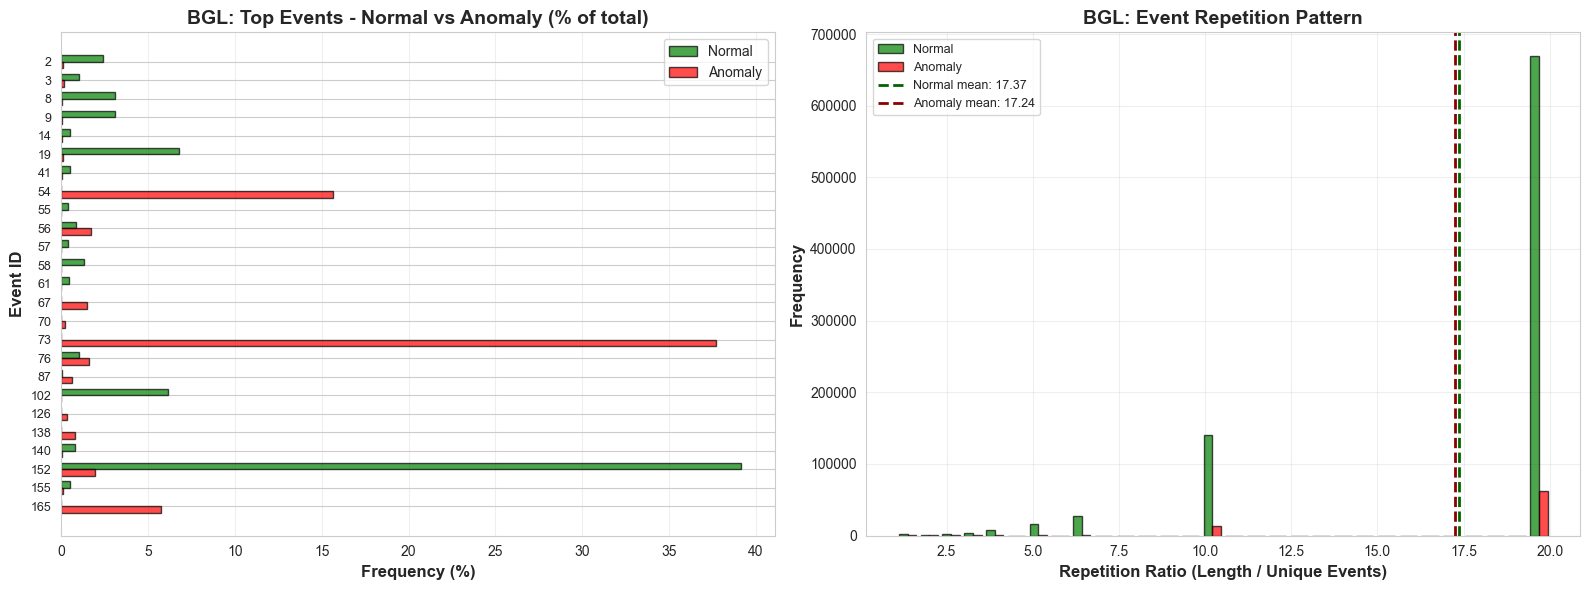

✓ Saved: ../figures/bgl_normal_vs_anomaly_events.png


In [15]:
# === NORMAL VS ANOMALY EVENT COMPARISON ===
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Top events in Normal vs Anomaly
top_n = 25
top_normal = normal_event_counts.most_common(top_n)
top_anomaly = anomaly_event_counts.most_common(top_n)

# Get union of top events from both classes
all_top_events = set([e[0] for e in top_normal] + [e[0] for e in top_anomaly])
all_top_events = sorted(list(all_top_events))[:top_n]  # Limit to top_n

normal_freqs = [normal_event_counts.get(e, 0) for e in all_top_events]
anomaly_freqs = [anomaly_event_counts.get(e, 0) for e in all_top_events]

# Normalize by total events in each class
normal_freqs_pct = [f / len(normal_events) * 100 for f in normal_freqs]
anomaly_freqs_pct = [f / len(anomaly_events) * 100 for f in anomaly_freqs]

x = np.arange(len(all_top_events))
width = 0.35

bars1 = axes[0].barh(x - width/2, normal_freqs_pct, width, label='Normal',
                    color='green', alpha=0.7, edgecolor='black')
bars2 = axes[0].barh(x + width/2, anomaly_freqs_pct, width, label='Anomaly',
                    color='red', alpha=0.7, edgecolor='black')

axes[0].set_yticks(x)
axes[0].set_yticklabels([f'{e}' for e in all_top_events], fontsize=9)
axes[0].set_xlabel('Frequency (%)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Event ID', fontsize=12, fontweight='bold')
axes[0].set_title(f'BGL: Top Events - Normal vs Anomaly (% of total)',
                fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# Plot 2: Event repetition pattern
normal_repetition = []
anomaly_repetition = []

for i, seq in enumerate(sequences):
    non_padding = seq[seq > 0]
    if len(non_padding) > 0:
        unique_count = len(set(non_padding))
        repetition = len(non_padding) / unique_count if unique_count > 0 else 0

        if labels[i] == 0:
            normal_repetition.append(repetition)
        else:
            anomaly_repetition.append(repetition)

axes[1].hist([normal_repetition, anomaly_repetition], bins=30,
            label=['Normal', 'Anomaly'], alpha=0.7, edgecolor='black',
            color=['green', 'red'])
axes[1].axvline(np.mean(normal_repetition), color='darkgreen', linestyle='--',
                linewidth=2, label=f'Normal mean: {np.mean(normal_repetition):.2f}')
axes[1].axvline(np.mean(anomaly_repetition), color='darkred', linestyle='--',
                linewidth=2, label=f'Anomaly mean: {np.mean(anomaly_repetition):.2f}')
axes[1].set_xlabel('Repetition Ratio (Length / Unique Events)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1].set_title('BGL: Event Repetition Pattern', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/bgl_normal_vs_anomaly_events.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: ../figures/bgl_normal_vs_anomaly_events.png")

In [17]:
summary_text = f"""
BGL DATASET SUMMARY FOR THESIS
{'='*80}

1. DATASET OVERVIEW
    - Source: BlueGene/L supercomputer at Lawrence Livermore National Labs
    - System: 131,072 processors, 32,768GB memory
    - Raw logs: 4,747,963 lines
    - Preprocessing: Drain3 parser + sliding window (size=20)

2. SEQUENCE STATISTICS
    - Total sequences: {n_sequences:,}
    - Normal sequences: {n_normal:,} ({n_normal/n_sequences*100:.2f}%)
    - Anomaly sequences: {n_anomaly:,} ({n_anomaly/n_sequences*100:.2f}%)
    - Anomaly rate: {anomaly_rate:.2f}%

3. TEMPLATE STATISTICS
    - Total templates discovered: {len(templates_df):,}
    - Vocabulary size: {len(vocabulary)}
    - Template diversity: HIGH (compared to HDFS's 29 templates)

4. SEQUENCE CHARACTERISTICS
    - Fixed window size: {sequences.shape[1]} events
    - Sequence length (excluding padding):
    * Mean: {np.mean(seq_lengths):.2f}
    * Median: {np.median(seq_lengths):.0f}
    * Std: {np.std(seq_lengths):.2f}
    * Range: [{np.min(seq_lengths)}, {np.max(seq_lengths)}]
    
    - Event diversity (unique events per sequence):
    * Overall mean: {np.mean(event_diversity):.2f}
    * Normal mean: {np.mean(normal_diversity):.2f}
    * Anomaly mean: {np.mean(anomaly_diversity):.2f}
    
    - Event repetition ratio (length / unique events):
    * Normal mean: {np.mean(normal_repetition):.2f}
    * Anomaly mean: {np.mean(anomaly_repetition):.2f}

5. EVENT STATISTICS
    - Total events (tokens): {len(all_events):,}
    - Unique events used: {len(event_counts)}
    - Events in normal sequences: {len(normal_events):,}
    - Events in anomaly sequences: {len(anomaly_events):,}

6. KEY INSIGHTS
    - More complex system: {len(templates_df)} templates (vs 29 in HDFS)
    - Better class balance: {anomaly_rate*100:.2f}% anomalies (vs 2.93% in HDFS)
    - Fixed-length sequences simplify sequential modeling
    - Larger vocabulary requires more embedding capacity
    - More training data available ({n_sequences:,} sequences)

{'='*80}
"""

with open('../figures/bgl_dataset_summary.txt', 'w') as f:
    f.write(summary_text)

print("\n✓ Summary saved to: ../figures/bgl_dataset_summary.txt")
print(summary_text)



✓ Summary saved to: ../figures/bgl_dataset_summary.txt

BGL DATASET SUMMARY FOR THESIS

1. DATASET OVERVIEW
    - Source: BlueGene/L supercomputer at Lawrence Livermore National Labs
    - System: 131,072 processors, 32,768GB memory
    - Raw logs: 4,747,963 lines
    - Preprocessing: Drain3 parser + sliding window (size=20)

2. SEQUENCE STATISTICS
    - Total sequences: 949,589
    - Normal sequences: 868,556 (91.47%)
    - Anomaly sequences: 81,033 (8.53%)
    - Anomaly rate: 8.53%

3. TEMPLATE STATISTICS
    - Total templates discovered: 369
    - Vocabulary size: 371
    - Template diversity: HIGH (compared to HDFS's 29 templates)

4. SEQUENCE CHARACTERISTICS
    - Fixed window size: 20 events
    - Sequence length (excluding padding):
    * Mean: 20.00
    * Median: 20
    * Std: 0.00
    * Range: [20, 20]

    - Event diversity (unique events per sequence):
    * Overall mean: 1.41
    * Normal mean: 1.40
    * Anomaly mean: 1.60

    - Event repetition ratio (length / unique ev